In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions.functions import EmissionProfile, AbsoluteMetricsPulseDefaultCO2, AbsoluteMetrics, RelativeMetrics
from climate_models.fair_emulator import BackgroundSpeciesQuantities, FaIRClimateModel, GWPStarEquivalentEmissionsFunction

## Parameters

In [2]:
co2_method = 'FaIR' # IPCC or FaIR
start_year = 1765
t0 = 2020

## Metrics calculation

In [3]:
j = 0
time_horizon_range = range(20,160,10)
gwp = np.zeros((len(time_horizon_range),6))
egwp = np.zeros((len(time_horizon_range),6))
gtp = np.zeros((len(time_horizon_range),6))
ratr = np.zeros((len(time_horizon_range),6))

for studied_species in ["Aviation CO2", "Aviation contrails", "Aviation NOx", "Aviation H2O", "Aviation soot", "Aviation sulfur"]:
    
    if studied_species == "Aviation CO2":
        sensitivity_erf = 0 # Not used
        ratio_erf_rf = 1
        unit_value = 1*10**10
    elif studied_species == "Aviation contrails":
        sensitivity_erf = 9.36e-13
        ratio_erf_rf = 0.42
        unit_value = 1*10**10
    elif studied_species == "Aviation NOx":
        sensitivity_erf = [34.4e-12 * (14/46), -9.3e-12 * (14/46), -18.7e-12 * (14/46), -2.8e-12 * (14/46)]
        ratio_erf_rf = [1.37, 1.18, 1.18, 1.18]
        unit_value = 1*10**8
    elif studied_species == "Aviation H2O":
        sensitivity_erf = 0.0052e-12
        ratio_erf_rf = 1
        unit_value = 1*10**12
    elif studied_species == "Aviation soot":
        sensitivity_erf = 100.7e-12 # Not used
        ratio_erf_rf = 1
        unit_value = 1*10**14
    elif studied_species == "Aviation sulfur":
        sensitivity_erf = -19.9e-12 # Not used
        ratio_erf_rf = 1
        unit_value = 1*10**9
        
    k = 0
    for time_horizon in time_horizon_range:
        end_year = t0 + time_horizon
        
        background_species_quantities = BackgroundSpeciesQuantities(start_year, end_year, rcp='RCP45')
        emission_profile = EmissionProfile(start_year,t0,time_horizon, 'pulse', unit_value)
        
        if co2_method == 'IPCC':
            radiative_forcing_co2, agwp_co2, aegwp_co2, temperature_co2, agtp_co2, iagtp_co2, atr_co2 = AbsoluteMetricsPulseDefaultCO2(time_horizon, unit_value)
        elif co2_method == 'FaIR':
            sensitivity_erf_co2 = 0 # Not used
            ratio_erf_rf_co2 = 1
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = FaIRClimateModel(start_year, end_year, background_species_quantities, emission_profile, "Aviation CO2", sensitivity_erf_co2, ratio_erf_rf_co2)
            agwp_co2, aegwp_co2, agtp_co2, iagtp_co2, atr_co2 = AbsoluteMetrics(radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2, time_horizon)
            
        radiative_forcing, effective_radiative_forcing, temperature = FaIRClimateModel(start_year, end_year, background_species_quantities, emission_profile, studied_species, sensitivity_erf, ratio_erf_rf)
        agwp, aegwp, agtp, iagtp, atr = AbsoluteMetrics(radiative_forcing, effective_radiative_forcing, temperature, time_horizon)
        
        gwp[k,j], egwp[k,j], gtp[k,j], igtp, ratr[k,j] = RelativeMetrics(agwp_co2, aegwp_co2, agtp_co2, iagtp_co2, atr_co2, agwp, aegwp, agtp, iagtp, atr)
        
        k += 1
        
    j += 1

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/275 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/285 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/295 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/315 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/325 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/335 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/345 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/355 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/365 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/375 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/385 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/395 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/405 [00:00<?, ?timesteps/s]

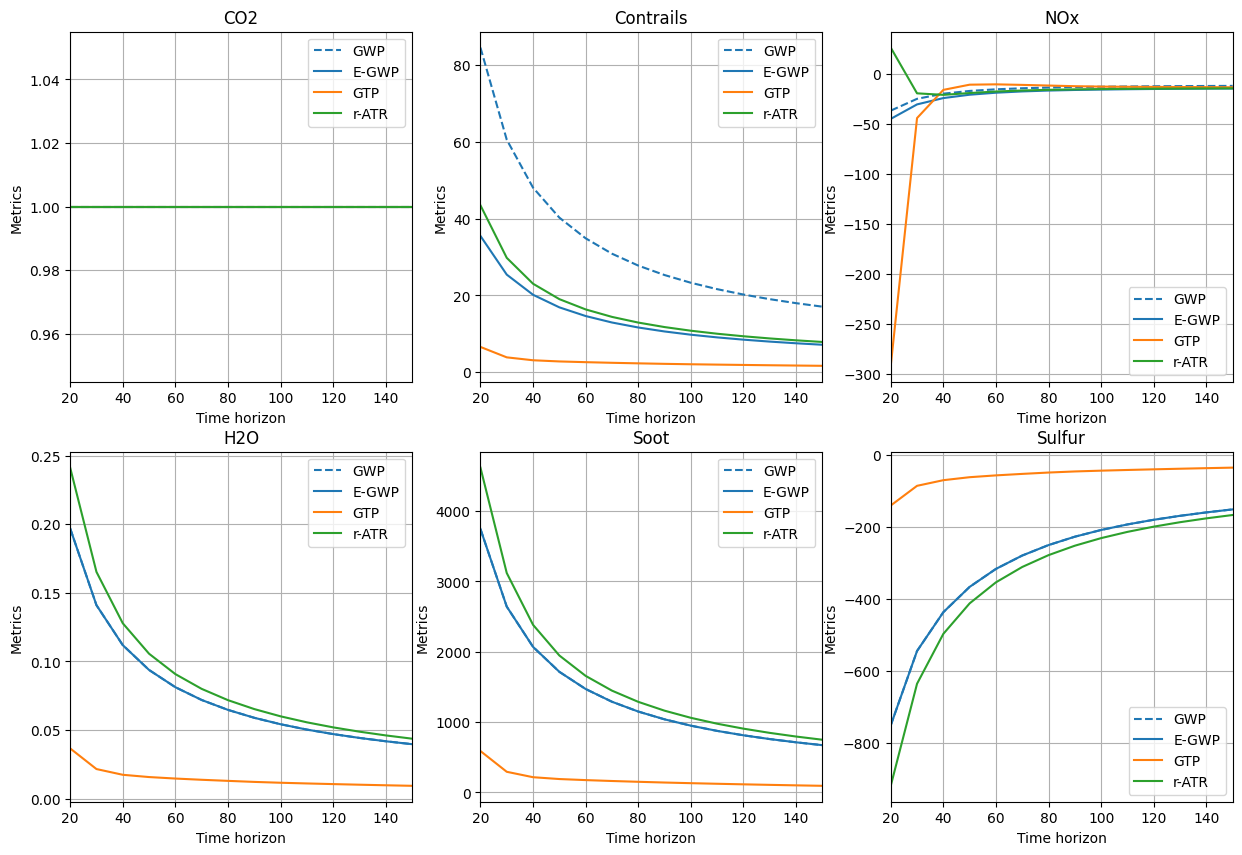

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    x_axis = time_horizon_range
    ax.plot(x_axis, gwp[:, i], label='GWP', color='C0', linestyle='--')
    ax.plot(x_axis, egwp[:, i], label='E-GWP', color='C0')
    ax.plot(x_axis, gtp[:, i], label='GTP', color='C1')
    ax.plot(x_axis, ratr[:, i], label='r-ATR', color='C2')
    ax.set_xlim(min(time_horizon_range),max(time_horizon_range))
    ax.set_xlabel('Time horizon')
    ax.set_ylabel('Metrics')
    if i == 0:
        ax.set_title('CO2')
    elif i == 1:
        ax.set_title('Contrails')
    elif i == 2:
        ax.set_title('NOx')
    elif i == 3:
        ax.set_title('H2O')
    elif i == 4:
        ax.set_title('Soot')
    elif i == 5:
        ax.set_title('Sulfur')
    ax.grid()
    ax.legend()
    
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()